# Pixel Modeling Experimentation

This notebook includes extensions to some of the functions available in the *pixel_modeling.py* script as well as some other random experiments that I haven't packaged into functions. 

## Getting Started

 First let's import the all the relevant libraries and functions.

In [1]:
# import pixel modeling libraries and functions
import os
os.chdir(os.path.dirname(os.getcwd()) + '/code')
from pixel_modeling import *

## Sequential Effects

Instead of just modeling and predicting the pixel values of an image, let's chain together a sequence of algorithms where we model the output of the previous model!

In [2]:
# navigate to data directory
os.chdir(os.path.dirname(os.getcwd()) + '/data')

# open and process image
img1 = processImage('img1.jpg', grayscale = True)

First, let's try chaning together a bunch of k-nearest neighbors algorithms.

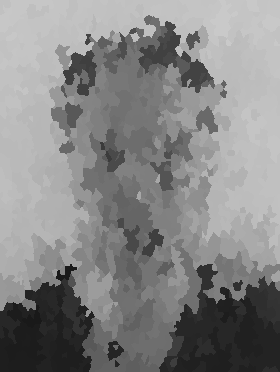

In [3]:
# knn
knn_chain_img = img1.copy()
for i in range(30):
    X, y = getIndexFeatures(knn_chain_img, poly_degree = 1)
    knn_chain_img = modelIndexWarp(X, y, prop_row = 0.05,
                                   mod = 'knn', nbs = 1,
                                   og_image_shape = asarray(knn_chain_img).shape)
knn_chain_img

Woah! Pretty ghoulish! Let's try combining a few different algorithms. I tried just choosing algorithms and parameters randomly but the results weren't overly interesting. K-nearest neighbors followed by gradient boosted trees with polynomial features was pretty wild, though!

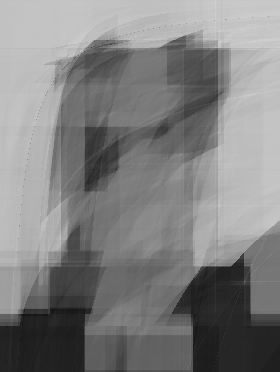

In [5]:
spec_chain_img0 = img1.copy()

X, y = getIndexFeatures(spec_chain_img0, poly_degree = 1)
spec_chain_img1 = modelIndexWarp(X, y,  prop_row = 0.001,
                                 mod = 'knn', nbs = 1,
                                 og_image_shape = asarray(spec_chain_img0).shape)

X, y = getIndexFeatures(spec_chain_img1, poly_degree = 5)
spec_chain_img2 = modelIndexWarp(X, y,  prop_row = 0.01,
                                 mod = 'xgb', nbs = 1,
                                 og_image_shape = asarray(spec_chain_img1).shape)

spec_chain_img2

## Neural Networks

Let's build a simple multilayer perceptron (MLP) to predict pixel values from pixel coordinates (as we've done with other models). The cool thing about MLP's is that there are endless ways to tinker with the architecture and hyperparameters. I'd like to emphasize that I'm tinkering with architecture and parameters to get cool effects, not to actually do a good job of reconstructing the original image!

In [6]:
# import tensorflow/keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [7]:
# setup and sample data
X, y = getIndexFeatures(img1, poly_degree = 10)
prop_row = 0.05
row_sample = np.random.choice(range(X.shape[0]), size=round(prop_row*X.shape[0]), replace = False)
X_sample = X[row_sample, :]
y_sample = y[row_sample]

In [8]:
# initialize model
mlp = Sequential()
mlp.add(Dense(512, input_shape=(X_sample.shape[1],), activation='relu'))
mlp.add(Dense(256, activation='sigmoid'))
mlp.add(Dense(128, activation='linear'))
mlp.add(Dense(64, activation='sigmoid'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mse', 
            optimizer='adam', 
            metrics=['mse'])

In [10]:
# fit the model
mlp.fit(X_sample, y_sample,
        batch_size=32,
        epochs=100,
        verbose=0,
        validation_split=0.1,
        shuffle=True)

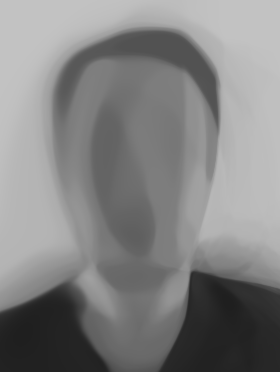

In [145]:
# predict pixel values and organize them into an image
pred_y = mlp.predict(X)
pred_y = np.round(pred_y)
pred_y = np.clip(pred_y, 0, 255)
pred_img = convertIndexToImage(asarray(img1).shape, pred_y)
result = Image.fromarray(np.uint8(pred_img))
result

## Color

As a starting point, we can work with color similarly to how we've been working with grayscale images, except that there is now a third dimension! Whereas before we just have a single 2-D matrix of pixel values, we will have 3 stacked 2-D matrices corresponding to the red, green, and blue channels. Also, as the model predictino error will not translate to just a warped image but also warped colors! Let's load a color image of an oak tree not far from where I live.

In [13]:
# open and process image
img2 = processImage('img2.jpg', grayscale = False)

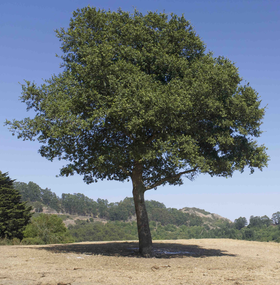

In [14]:
img2

First, let's modify our getIndexFeatures() function to allow for a third dimension.

In [16]:
def getIndexFeaturesColor(img, poly_degree):
    
    # convert image to array
    img_t = asarray(img)

    # create empty feature matrix
    X = np.empty((img_t.shape[0]*img_t.shape[1]*img_t.shape[2], 3))
    y = np.empty(img_t.shape[0]*img_t.shape[1]*img_t.shape[2])

    # loop through image in row-major order to populate feature matrix 
    # and outcome vector, if specified
    i = 0
    for r in range(img_t.shape[0]):
        for c in range(img_t.shape[1]):
            for d in range(img_t.shape[2]):
                X[i, 0] = r
                X[i, 1] = c
                X[i, 2] = d
                y[i] = img_t[r, c, d]
                i = i + 1
    poly = PolynomialFeatures(poly_degree)
    X = poly.fit_transform(X)
    X = np.delete(X, 0, axis = 1)
    X = stats.zscore(X, axis = 0)
    
    # return
    return X, y

Let's apply it to our beautiful oak tree, fit a model to the pixel values and then reconstruct the image.

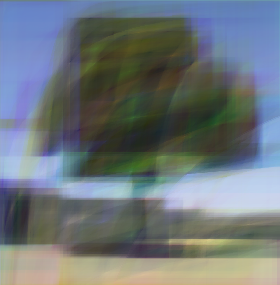

In [26]:
# set parameters
polyd = 10
prop_row=0.005

# get index features
X, y = getIndexFeaturesColor(img2, poly_degree=polyd)

# sample pixels to use for training
row_sample = np.random.choice(range(X.shape[0]), size=round(prop_row*X.shape[0]), replace = False)
X_sample = X[row_sample, :]
y_sample = y[row_sample]

# fit model to training sample
model = RandomForestRegressor()
reg = model.fit(X_sample, y_sample)

# predict pixel values, convert to integer and clip to 0-255
pred_y = reg.predict(X)
pred_y = np.round(pred_y)
pred_y = np.clip(pred_y, 0, 255)

# initialize empty array for resulting image
pred_img = np.empty(asarray(img2).shape)

# populate empty result array with predicted pixel values
# in row-major order
i = 0
for r in range(pred_img.shape[0]):
    for c in range(pred_img.shape[1]):
        for d in range(pred_img.shape[2]):
            pred_img[r, c, d] = pred_y[i]
            i = i + 1

# convert to image and display
result = Image.fromarray(np.uint8(pred_img))
result

There is a lot more that can be done with color, but this is just to get the creative gears turning!